In [ ]:
def load_df(file_path):
    cols=['id','category','gender','baseColour','season','usage','noisyTextDescription']
    df = pd.read_csv(file_path,header=0,names=cols)
    return df

In [ ]:
def load_test_df(file_path):
    cols=['id','gender','baseColour','season','usage','noisyTextDescription']
    df = pd.read_csv(file_path,header=0,names=cols)
    return df

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.4MB 13.4MB/s 
     |████████████████████████████████| 890kB 57.7MB/s 
     |████████████████████████████████| 2.9MB 47.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=4663b030ffa262285faced5597ce683fd1e96fe5d3740876d4717235e1c5e44c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification

# specify GPU
cuda = torch.cuda.is_available()
print(cuda)
device = torch.device("cuda" if cuda else "cpu")

True


# NoisyTextDescription Model

**Replace the test data directory in df_test**

In [ ]:
df = load_df('train.csv')
df_test=load_test_df('test.csv') # Replace the test data here

text = df['noisyTextDescription']
y = df['category']

possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df.category.replace(label_dict)

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['category', 'label', 'data_type']).count()

id  ...  noisyTextDescription
category                 label data_type        ...                      
Accessories              26    train        58  ...                    58
                               val           6  ...                     6
Apparel Set              25    train        54  ...                    54
                               val           6  ...                     6
Bags                     4     train      1365  ...                  1365
                               val         152  ...                   152
Belts                    14    train       344  ...                   344
                               val          38  ...                    38
Bottomwear               11    train      1193  ...                  1193
                               val         133  ...                   133
Cufflinks                23    train        45  ...                    45
                               val           5  ...                     5
Dress                    8     train       215  ...                   215
                               val          24  ...                    24
Eyewear                  19    train       478  ...                   478
                               val          53  ...                    53
Flip Flops               1     train       415  ...                   415
                               val          46  ...                    46
Fragrance                22    train       469  ...                   469
                               val          52  ...                    52
Free Gifts               24    train        55  ...                    55
                               val           6  ...                     6
Headwear                 9     train       115  ...                   115
                               val          13  ...                    13
Innerwear                12    train       819  ...                   819
                               val          91  ...                    91
Jewellery                10    train       473  ...                   473
                               val          53  ...                    53
Lips                     18    train       174  ...                   174
                               val          19  ...                    19
Loungewear and Nightwear 17    train       200  ...                   200
                               val          22  ...                    22
Makeup                   20    train       106  ...                   106
                               val          12  ...                    12
Nails                    16    train       135  ...                   135
                               val          15  ...                    15
Sandal                   3     train       417  ...                   417
                               val          46  ...                    46
Saree                    15    train       193  ...                   193
                               val          21  ...                    21
Scarves                  0     train        53  ...                    53
                               val           6  ...                     6
Shoes                    6     train      3246  ...                  3246
                               val         361  ...                   361
Socks                    5     train       306  ...                   306
                               val          34  ...                    34
Ties                     21    train       117  ...                   117
                               val          13  ...                    13
Topwear                  2     train      6920  ...                  6920
                               val         769  ...                   769
Wallets                  13    train       376  ...                   376
                               val          42  ...                    42
Watches                  7     train      1123  

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].noisyTextDescription.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].noisyTextDescription.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer  = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

  model.eval()
  
  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader_val:
      
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
                }

      with torch.no_grad():        
          outputs = model(**inputs)
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader_val) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals


# Train
  
for epoch in tqdm(range(1, epochs+1)):
  
  model.train()
  model.to(device)
  
  loss_train_total = 0
  best_valid_loss = float('inf')

  progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
  for batch in progress_bar:

      model.zero_grad()
      
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[2],
                }       

      move_to(inputs, device)
      outputs = model(**inputs)
      
      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()
      
      progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
      
  # torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
      
  tqdm.write(f'\nEpoch {epoch}')
  
  loss_train_avg = loss_train_total/len(dataloader_train)            
  tqdm.write(f'Training loss: {loss_train_avg}')
  
  val_loss, predictions, true_vals = evaluate(dataloader_validation)
  val_f1 = f1_score_func(predictions, true_vals)
  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(), 'saved_weights.pt')
    
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 1.4696239216378562
Validation loss: 0.8078816809198436
F1 Score (Weighted): 0.8062094495985987



Epoch 2
Training loss: 0.6721867392166886
Validation loss: 0.5974484239430988
F1 Score (Weighted): 0.853292764671957



Epoch 3
Training loss: 0.49964946297980684
Validation loss: 0.536097349051167
F1 Score (Weighted): 0.8691429490651585



Epoch 4
Training loss: 0.4166498072873587
Validation loss: 0.5139210469582501
F1 Score (Weighted): 0.8703768122380825



Epoch 5
Training loss: 0.37135474516571254
Validation loss: 0.5053573248579222
F1 Score (Weighted): 0.8753109881166808



In [ ]:
path = 'saved_weights.pt'

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
model.load_state_dict(torch.load(path))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)
print(predictions)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: Scarves
Accuracy: 5/6

Class: Flip Flops
Accuracy: 40/46

Class: Topwear
Accuracy: 729/769

Class: Sandal
Accuracy: 31/46

Class: Bags
Accuracy: 129/152

Class: Socks
Accuracy: 23/34

Class: Shoes
Accuracy: 331/361

Class: Watches
Accuracy: 116/125

Class: Dress
Accuracy: 16/24

Class: Headwear
Accuracy: 11/13

Class: Jewellery
Accuracy: 50/53

Class: Bottomwear
Accuracy: 107/133

Class: Innerwear
Accuracy: 77/91

Class: Wallets
Accuracy: 33/42

Class: Belts
Accuracy: 27/38

Class: Saree
Accuracy: 16/21

Class: Nails
Accuracy: 15/15

Class: Loungewear and Nightwear
Accuracy: 20/22

Class: Lips
Accuracy: 17/19

Class: Eyewear
Accuracy: 44/53

Class: Makeup
Accuracy: 3/12

Class: Ties
Accuracy: 11/13

Class: Fragrance
Accuracy: 47/52

Class: Cufflinks
Accuracy: 5/5

Class: Free Gifts
Accuracy: 0/6

Class: Apparel Set
Accuracy: 0/6

Class: Accessories
Accuracy: 1/6

[[-0.4820819  -0.24636835  6.5051103  ... -1.0419824   0.30140516
  -0.861261  ]
 [-1.2035954  -0.32632387  8.142064 

In [ ]:
print(true_vals)

[2 2 3 ... 2 6 2]


In [ ]:
def predict(dataloader_val):

  model.eval()
  
  predictions = []
  
  for batch in dataloader_val:
      
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                }

      with torch.no_grad():        
          outputs = model(**inputs)
          
      logits = outputs[0]

      logits = logits.detach().cpu().numpy()
      predictions.append(logits)

  
  predictions = np.concatenate(predictions, axis=0)
          
  return predictions

In [ ]:
encoded_data_test = tokenizer.batch_encode_plus(
    df_test.noisyTextDescription.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']

dataset_test = TensorDataset(input_ids_test, attention_masks_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=2)

pred = predict(dataloader_test)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[[-0.5576404  -0.68880785  0.6123346  ... -1.3182404  -0.31278378
  -0.70705765]
 [-1.0213221  -0.28529558  8.030048   ... -0.81152403 -0.41941145
  -0.84125805]
 [-0.33817586 -0.56005293 -0.29009488 ... -0.27671048  0.11916305
   0.49092016]
 ...
 [-1.3455716  -0.5635562   7.839084   ... -0.9111609  -0.82368463
  -1.0605593 ]
 [ 0.72761965 -0.38398656 -2.6224265  ...  0.643417    0.13910036
   0.7042126 ]
 [-0.9066349  -1.74883    -0.15913068 ... -0.16983972 -1.1802297
   0.3731588 ]]
[12  2  4 ...  2 18  4]
[12, 2, 4, 6, 6, 6, 2, 19, 7, 6, 12, 2, 21, 12, 5, 13, 7, 7, 11, 6, 16, 2, 11, 14, 14, 2, 4, 6, 13, 2, 2, 13, 2, 2, 2, 19, 7, 13, 7, 6, 2, 2, 11, 2, 7, 2, 3, 2, 2, 4, 7, 15, 12, 2, 2, 6, 13, 2, 2, 7, 6, 6, 6, 6, 8, 2, 2, 11, 2, 7, 3, 7, 2, 1, 7, 2, 2, 12, 2, 6, 2, 2, 2, 2, 7, 13, 2, 7, 19, 6, 11, 8, 2, 1, 2, 2, 6, 12, 6, 2, 6, 7, 23, 22, 11, 2, 6, 4, 3, 2, 10, 3, 2, 15, 4, 2, 6, 8, 2, 4, 2, 7, 4, 17, 12, 2, 2, 22, 9, 11, 2, 2, 2, 2, 2, 2, 13, 1, 2, 2, 2, 6, 10, 2, 2, 2, 16, 2, 7, 

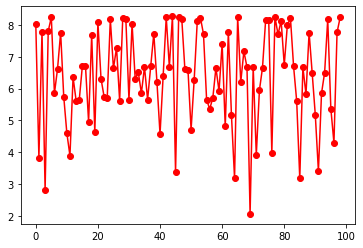

In [ ]:
import math
import matplotlib.pyplot as plt

print(pred)
print(np.argmax(pred, axis=1).flatten())
print([x.argmax() for x in pred])
print([x.max() for x in pred])

print(len([x for x in [x.max() for x in pred] if x < 4]))
print(len([x.max() for x in pred]))

plt.plot([x.max() for x in pred][1:100], '-ro')
plt.show()

In [ ]:
label_dict_inverse = {v: k for k, v in label_dict.items()}
preds_flat = np.argmax(pred, axis=1).flatten()
text_result = []
for i in preds_flat:
  text_result.append(label_dict_inverse[i])
ids=[]
n=len(df_test.index)
for i in range(n):
    ids.append(df_test.at[i,'id'])
# submission=pd.DataFrame({'id':ids,'category':text_result}, columns= ['id', 'category'])
# submission.to_csv('submission.csv',index=False,header=True)

# Image Model

In [ ]:
import cv2

def load_images(df):
    images=[]
    n=len(df.index)
    for i in range(n):
        id=df.at[i,'id']
        image=cv2.imread('suffled-images/shuffled-images/'+str(id)+'.jpg')
        images.append(image)
    return np.array(images)

****Replace the test data directory in df_test****

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

df = load_df('train.csv')
df_test=load_test_df('test.csv') # Replace the test data here

text = df['noisyTextDescription']
y = df['category']

possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df.category.replace(label_dict)

images = load_images(df)

X_train, X_val, y_train, y_val = train_test_split(images,
                                                  df.label.values, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

y_train = to_categorical(y_train, 27)
y_val = to_categorical(y_val, 27)
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

print("X_train shape", X_train.shape)

X_train shape (19464, 80, 60, 3)


In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

# # build a sequential model
# model = Sequential()
# model.add(InputLayer(input_shape=(80, 60, 3)))

# # 1st conv block
# model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# # 2nd conv block
# model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# model.add(BatchNormalization())
# # 3rd conv block
# model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
# model.add(BatchNormalization())
# # ANN block
# model.add(Flatten())
# model.add(Dense(units=100, activation='relu'))
# model.add(Dense(units=100, activation='relu'))
# model.add(Dropout(0.25))
# # output layer
# model.add(Dense(units=27, activation='softmax'))

# # compile model
# model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# # fit on data for 30 epochs
# model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=datagen.flow(X_val, y_val, batch_size=32))

In [ ]:
X_train = X_train / 255
X_val = X_val / 255

In [ ]:
!pip install livelossplot

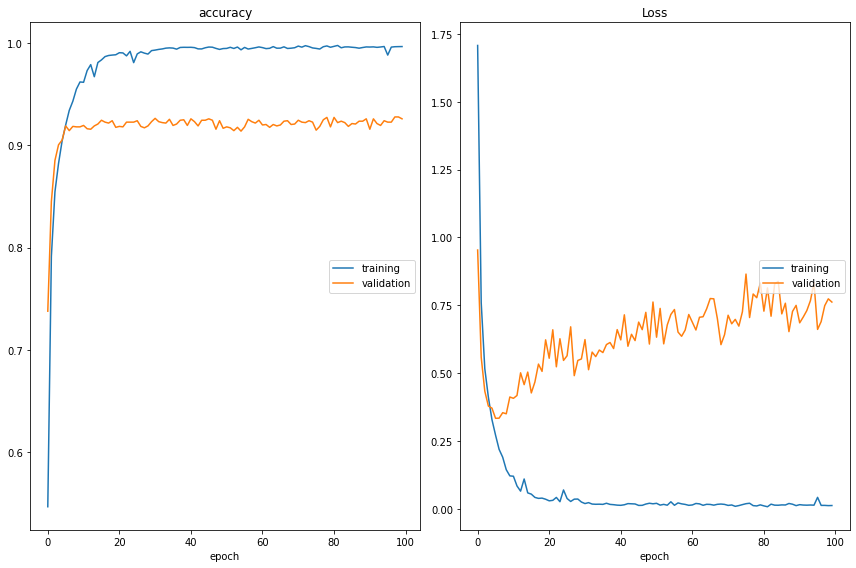

accuracy
	training         	 (min:    0.547, max:    0.998, cur:    0.997)
	validation       	 (min:    0.738, max:    0.928, cur:    0.926)
Loss
	training         	 (min:    0.008, max:    1.707, cur:    0.012)
	validation       	 (min:    0.334, max:    0.954, cur:    0.762)

Epoch 00100: val_accuracy did not improve from 0.92788
77/77 [==============================] - 2s 30ms/step - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.7619 - val_accuracy: 0.9260


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(80, 60, 3)))
model2.add(Conv2D(32, (3, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(1000, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(250, activation='relu'))
model2.add(Dense(27, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

save_best_model = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

model2.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=['accuracy'])

hist = model2.fit(X_train, y_train, 
           batch_size=256, epochs=100, validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), save_best_model])

In [ ]:
from keras.models import load_model

model2=load_model('./best_cnn_model.h5')
n=len(df_test.index)
images=load_images(df_test)
ids=[]
for i in range(n):
    ids.append(df_test.at[i,'id'])
datagen.fit(images)
images = images / 255
predictions = model2.predict(images)
confidence = [x.max() for x in predictions]
print([x.max() for x in predictions])
print(len([x for x in confidence if x < 0.8]))
print(len(confidence))

[0.9999838, 0.99999964, 1.0, 1.0, 1.0, 1.0, 0.99995816, 1.0, 1.0, 1.0, 1.0, 0.99999976, 1.0, 1.0, 0.9999547, 1.0, 0.9998971, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977093, 1.0, 1.0, 0.99971527, 1.0, 1.0, 0.9303353, 1.0, 0.9999999, 0.9886934, 0.9928604, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99974996, 0.9998267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997012, 1.0, 1.0, 0.9264599, 1.0, 0.96020675, 1.0, 1.0, 0.5734555, 1.0, 1.0, 1.0, 1.0, 0.9999993, 0.53916454, 0.99999964, 1.0, 1.0, 1.0, 0.9999999, 1.0, 0.9825386, 1.0, 1.0, 0.99999833, 0.99998426, 0.99999976, 1.0, 1.0, 0.9730241, 1.0, 1.0, 0.9999999, 0.99995124, 1.0, 0.9888236, 1.0, 0.9999987, 0.9077859, 0.99999857, 0.9999763, 0.9999888, 1.0, 1.0, 1.0, 0.9999858, 1.0, 0.98915464, 0.9985505, 1.0, 0.999982, 1.0, 1.0, 0.9999994, 0.99998164, 0.90612316, 1.0, 0.86847764, 1.0, 0.99999964, 0.91190654, 0.86493534, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9842258, 1.0, 0.9999856, 1.0, 0.96086323, 1.0, 1.0, 1.0, 1.0, 0.99761, 1.0, 1.0, 1.0, 0

In [ ]:
print(len([x for x in confidence if x < 1]))

7439


# Combine Results

In [ ]:
scores = [x.max() for x in pred]
print([x.argmax() for x in predictions])
preds = [x.argmax() for x in predictions]
label_dict_inverse = {v: k for k, v in label_dict.items()}
image_result = []
for i in preds:
  image_result.append(label_dict_inverse[i])


final_result = []
cnt = 0
for i in range(len(image_result)):
  if confidence[i] < 1 and scores[i] >= 5:
    cnt += 1
    final_result.append(text_result[i])
  else:
    final_result.append(image_result[i])
submission=pd.DataFrame({'id':ids,'category':final_result}, columns= ['id', 'category'])
submission.to_csv('submission.csv',index=False,header=True)

[12, 2, 14, 6, 12, 6, 2, 19, 7, 6, 12, 2, 21, 12, 5, 13, 7, 7, 11, 6, 16, 2, 11, 14, 14, 2, 4, 6, 13, 2, 2, 13, 2, 11, 2, 19, 7, 13, 7, 6, 2, 2, 11, 2, 7, 2, 1, 2, 2, 4, 7, 15, 12, 2, 2, 6, 13, 11, 12, 6, 6, 6, 6, 6, 8, 6, 2, 11, 2, 7, 5, 7, 2, 1, 7, 2, 2, 10, 2, 6, 2, 2, 2, 2, 7, 4, 11, 7, 19, 6, 2, 8, 6, 1, 10, 2, 6, 12, 6, 2, 6, 7, 23, 22, 25, 2, 6, 4, 3, 2, 11, 6, 2, 15, 4, 2, 6, 15, 2, 4, 2, 7, 4, 2, 12, 2, 2, 22, 9, 11, 2, 2, 2, 2, 2, 6, 13, 1, 2, 2, 2, 6, 10, 2, 2, 2, 16, 2, 4, 2, 12, 4, 2, 17, 2, 12, 19, 11, 2, 2, 7, 22, 16, 4, 2, 2, 3, 18, 2, 8, 2, 2, 2, 4, 16, 2, 4, 2, 2, 2, 1, 2, 2, 15, 7, 22, 2, 18, 2, 1, 5, 13, 6, 18, 2, 2, 2, 16, 2, 11, 12, 2, 1, 4, 22, 4, 2, 2, 4, 10, 7, 7, 6, 12, 6, 6, 2, 22, 2, 2, 1, 2, 4, 2, 6, 6, 3, 2, 0, 7, 12, 2, 2, 7, 7, 13, 2, 6, 7, 2, 6, 2, 2, 22, 6, 4, 2, 2, 2, 6, 10, 6, 6, 2, 6, 2, 2, 2, 4, 6, 22, 4, 2, 12, 6, 14, 7, 2, 6, 22, 8, 2, 6, 2, 2, 1, 2, 2, 21, 6, 7, 2, 2, 11, 2, 2, 6, 2, 5, 11, 1, 2, 2, 3, 11, 2, 5, 6, 11, 6, 25, 6, 2, 6, 2, 11, 6, 

In [ ]:
print(cnt)

5783
